In [1]:

import pandas as pd
import matplotlib.pyplot as plt


In [2]:
## read xyz-billing file initially
xyz_billing = pd.read_csv(r"xyz-billing.csv", 
                          parse_dates = True,
                          #index_col = 1
                          )

#ensure date time 
xyz_billing.date = pd.to_datetime(xyz_billing.date)


/var/folders/vr/5n4246kj55721t8zj6nrlj_c0000gn/T/ipykernel_55810/508073817.py:8: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  xyz_billing.date = pd.to_datetime(xyz_billing.date)


In [3]:
#do for the physical calendar purchases and monthly purchases first

#xyz_billing['month'] = xyz_billing.index.month
xyz_billing_month = xyz_billing\
                    .loc[xyz_billing["itemDescription"]
                                    .isin(["calendar purchase",
                                           "monthly subscription"])]

#new cols for month and year
xyz_billing_month = xyz_billing_month\
                    .assign(month = xyz_billing_month.date.dt.month,
                            year = xyz_billing_month.date.dt.year,
                            MRR = xyz_billing_month.amount
                            )

#aggregate by year and month

xyz_physical_month_MRR = xyz_billing_month\
                            .groupby(["year","month"])\
                                .agg({'MRR':'sum'})

In [4]:

#do for the annual calendar purchases
xyz_billing_annually = xyz_billing\
                        .loc[xyz_billing["itemDescription"] == "annual subscription"]

#create list of dfs and concat together
#in each list item offset month further by 1
#also add column MRR by dividing amount by 12
annual_list = [xyz_billing_annually\
                         .assign(date = 
                                 xyz_billing_annually['date'] + 
                                 pd.DateOffset(months=i),
                                 MRR = xyz_billing_annually['amount'] / 12
                                 ) for i in range(1,13)]

xyz_billing_annual = pd.concat(annual_list)

xyz_billing_annual = xyz_billing_annual\
                    .assign(month = xyz_billing_annual.date.dt.month,
                            year = xyz_billing_annual.date.dt.year
                            ) 

xyz_annual_MRR = xyz_billing_annual\
                            .groupby(["year","month"])\
                                .agg({'MRR':'sum'})


In [5]:
#concatenate the two MRR tables together

xyz_MRR = pd.concat([xyz_annual_MRR, xyz_physical_month_MRR]).sort_index()
xyz_MRR = xyz_MRR.reset_index().groupby(["year","month"]).sum() #reaggregate


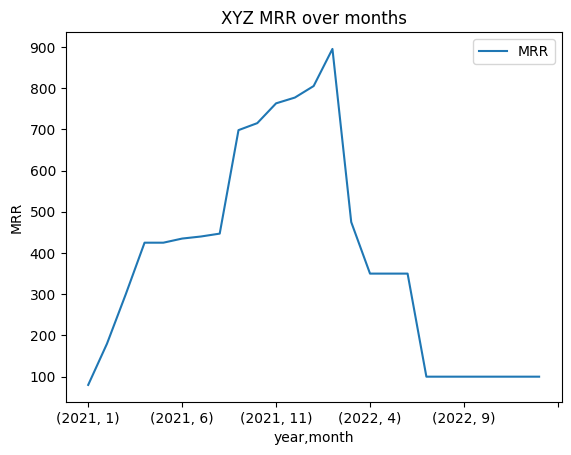

              MRR
year month       
2021 1       80.0
     2      180.0
     3      300.0
     4      425.0
     5      425.0
     6      435.0
     7      440.0
     8      447.0
     9      698.0
     10     715.0
     11     763.0
     12     777.0
2022 1      805.0
     2      895.0
     3      475.0
     4      350.0
     5      350.0
     6      350.0
     7      100.0
     8      100.0
     9      100.0
     10     100.0
     11     100.0
     12     100.0
2023 1      100.0


In [6]:

xyz_MRR.plot(kind="line", title = "XYZ MRR over months", ylabel = "MRR")
plt.show()
print(xyz_MRR)

In [7]:

xyz_payment_schedule = pd.concat([xyz_billing_annual,xyz_billing_month])\
                        .sort_values("date")


/var/folders/vr/5n4246kj55721t8zj6nrlj_c0000gn/T/ipykernel_55810/3231763050.py:7: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  xyz_growth_pct = xyz_growth.pct_change().drop("All")


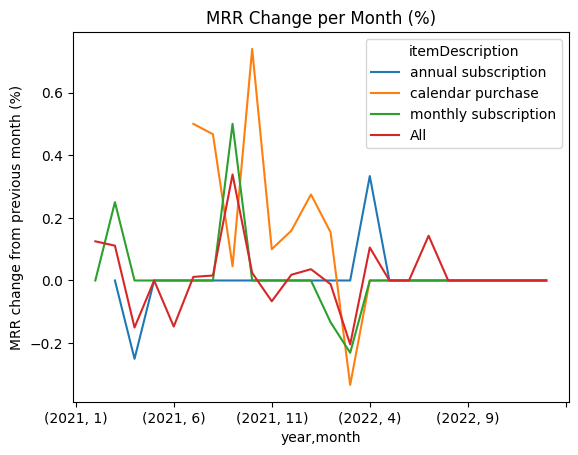

itemDescription  annual subscription  calendar purchase  monthly subscription  \
year month                                                                      
2021 1                           NaN                NaN                   NaN   
     2                           NaN                NaN              0.000000   
     3                      0.000000                NaN              0.250000   
     4                     -0.250000                NaN              0.000000   
     5                      0.000000                NaN              0.000000   
     6                      0.000000                NaN              0.000000   
     7                      0.000000           0.500000              0.000000   
     8                      0.000000           0.466667              0.000000   
     9                      0.000000           0.045455              0.500000   
     10                     0.000000           0.739130              0.000000   
     11                     

In [8]:
xyz_growth = xyz_payment_schedule\
                .pivot_table(values = "MRR", 
                             index = ["year","month"], 
                             columns = "itemDescription",
                             margins = True)

xyz_growth_pct = xyz_growth.pct_change().drop("All")

xyz_growth_pct.plot(kind="line", 
                    title = "MRR Change per Month (%)", 
                    ylabel = "MRR change from previous month (%)")
plt.show()
print(xyz_growth_pct)


/var/folders/vr/5n4246kj55721t8zj6nrlj_c0000gn/T/ipykernel_55810/1672470633.py:17: DeprecationWarning: Series._data is deprecated and will be removed in a future version. Use public APIs instead.
  xyz_customer = xyz_customer\


customerID  Customer6  customer1  customer10  customer11  customer12  \
year month                                                             
2021 1            0.0        0.0         0.0         0.0         0.0   
     2            0.0      100.0         0.0         0.0         0.0   
     3          120.0      100.0         0.0         0.0         0.0   
     4          120.0      100.0         0.0         0.0         0.0   
     5          120.0      100.0         0.0         0.0         0.0   
     6          120.0      100.0         0.0         0.0         0.0   
     7          120.0      100.0         0.0         0.0         0.0   
     8          120.0      100.0         0.0         0.0         0.0   
     9          120.0      100.0         0.0         0.0         0.0   
     10         120.0      100.0         0.0         0.0         0.0   
     11         120.0      100.0         0.0         0.0         0.0   
     12         120.0      100.0        52.0         0.0        

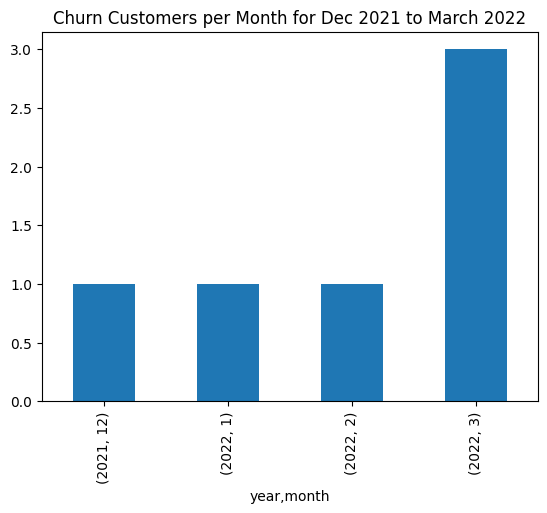

year  month
2021  12       1
2022  1        1
      2        1
      3        3
dtype: int64


In [9]:
#create new dataframe to reindex in case any months/years are not accounted for in data and replace with 0
#create new index (make sure all months in the calendar are accounted for)

date_reindex = pd.DataFrame({"date": pd.date_range(min(xyz_payment_schedule.date),
                                                    max(xyz_payment_schedule.date), 
                                                    freq = 'M')})
date_reindex = date_reindex.assign(month = date_reindex.date.dt.month, 
                                  year = date_reindex.date.dt.year)\
                                  .drop("date", axis = 1)

#create pivot per customer - the ones starting with 0s are months where they have churned
xyz_customer = xyz_payment_schedule.pivot_table(values = "MRR",
                                                index = ["year","month"],
                                                columns = "customerID")

#reindex capture all dates
xyz_customer = xyz_customer\
                .reindex([date_reindex.year,date_reindex.month],fill_value = 0)\
                        .fillna(0)

def check_customer(x):
    return((x.shift(1) != 0) & (x == 0))

xyz_churn = xyz_customer.apply(check_customer, axis = 0).loc[(2021,12):(2022,3),:]
xyz_churn = xyz_churn.sum(axis = 1)

print(xyz_customer)

xyz_churn.plot(kind = "bar", title = "Churn Customers per Month for Dec 2021 to March 2022")
plt.show()

print(xyz_churn)
